# Bangla Digit Recognition

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, AveragePooling2D, Flatten, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import model_from_json

### Global

In [20]:
IMG_SIZE = 32

### Read Images

In [4]:
def read_images(path):
    images = []
    labels = []
    
    for file_name in os.listdir(path):
        file_path = path + '/' + file_name
        for img_name in os.listdir(file_path):
            if not img_name.startswith('.'):
                if img_name.endswith('.png'):
                    img = cv2.imread(file_path + '/' + img_name)
                    new_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    image = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
                    images.append(image)
                    labels.append(file_name)
    return np.array(images), np.array(labels)

### Save model:

In [5]:
def save_model(model):
    model_json = model.to_json()
    with open("models/eye_status_model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("models/eye_status_model.h5")
    print("Model saved")

### Model:

#### Model 1:

In [43]:
def train_model1():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(MaxPool2D(strides=2))
    
    model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
    model.add(MaxPool2D(strides=2))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Dense(84, activation='softmax'))
    
    model.build()
    model.summary()
    
    return model

#### model2 LeNet5:

## Main Cells

### Read Images:

In [7]:
full_data_x, full_data_y = read_images('BanglaLekha-Isolated/Images')

In [8]:
print("dataset size : ", full_data_x.shape, full_data_y.shape)

dataset size :  (166105, 32, 32) (166105,)


### train and validation set:

In [9]:
train_imgs, val_imgs, train_y, val_y = train_test_split(full_data_x, full_data_y, test_size=0.2)

In [10]:
print("Train data :", train_imgs.shape, "       Label: ", train_y.shape) 
print("Validation data :", val_imgs.shape, "   Label: ", val_y.shape)

Train data : (132884, 32, 32)        Label:  (132884,)
Validation data : (33221, 32, 32)    Label:  (33221,)


### Save train, validation data:

In [11]:
np.save('data/train_imgs.npy', train_imgs)
np.save('data/train_y.npy', train_y)
np.save('data/val_imgs.npy', val_imgs)
np.save('data/val_y.npy', val_y)

### Load:

In [12]:
train_imgs = np.load('data/train_imgs.npy')
train_y = np.load('data/train_y.npy')
val_imgs = np.load('data/val_imgs.npy')
val_y = np.load('data/val_y.npy')

In [13]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape

((132884, 32, 32), (33221, 32, 32), (132884,), (33221,))

### Data Visualization:

65


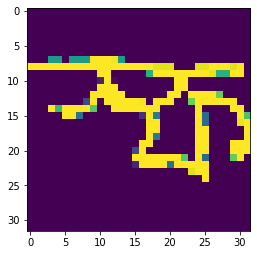

In [14]:
plt.figure(figsize=(4,10))
plt.imshow(train_imgs[0])
print(train_y[0])

### Reshape data:

In [49]:
X_train = np.reshape(train_imgs, (train_imgs.shape[0], train_imgs.shape[1], train_imgs.shape[2], 1))
X_test = np.reshape(val_imgs, (val_imgs.shape[0], val_imgs.shape[1], val_imgs.shape[2], 1))
y_train = train_y
y_test = val_y

In [54]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((132884, 32, 32, 1), (33221, 32, 32, 1), (132884,), (33221,))

In [55]:
# Normalize inputs
X_dev = X_train / 255.0

In [56]:
# Data Augmentation
datagen = ImageDataGenerator(
            rotation_range=10, 
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            zoom_range=0.1)
datagen.fit(X_dev)

### Train model:

In [57]:
model1 = train_model1()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 32)        832       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 48)        38448     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 48)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               442624    
_________________________________________________________________
dense_20 (Dense)             (None, 128)              

In [58]:
adam = Adam(lr=5e-4)
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [59]:
# Set a learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)

In [60]:
model1.fit_generator(datagen.flow(X_train, y_train, batch_size=100), steps_per_epoch=len(X_train)/100, 
                    epochs=10, validation_data=(X_test, y_test), callbacks=[reduce_lr])

ValueError: Error when checking target: expected dense_21 to have shape (84,) but got array with shape (1,)

NameError: name 'MaxPool2D' is not defined

In [ ]:
save_model(model)

### Testing:

In [ ]:
predictions = model.evaluate(X_test,y_test)
print("Accurecy ", predictions[1]*100)